In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from gridworld_env import GridWorld
from utils import paint_gridworld

## Checking the initial environments.
Construct a `GridWorld` with appropriate input arguments for each of the two tasks. Use `paint_gridworld` to plot the resulting environments. 

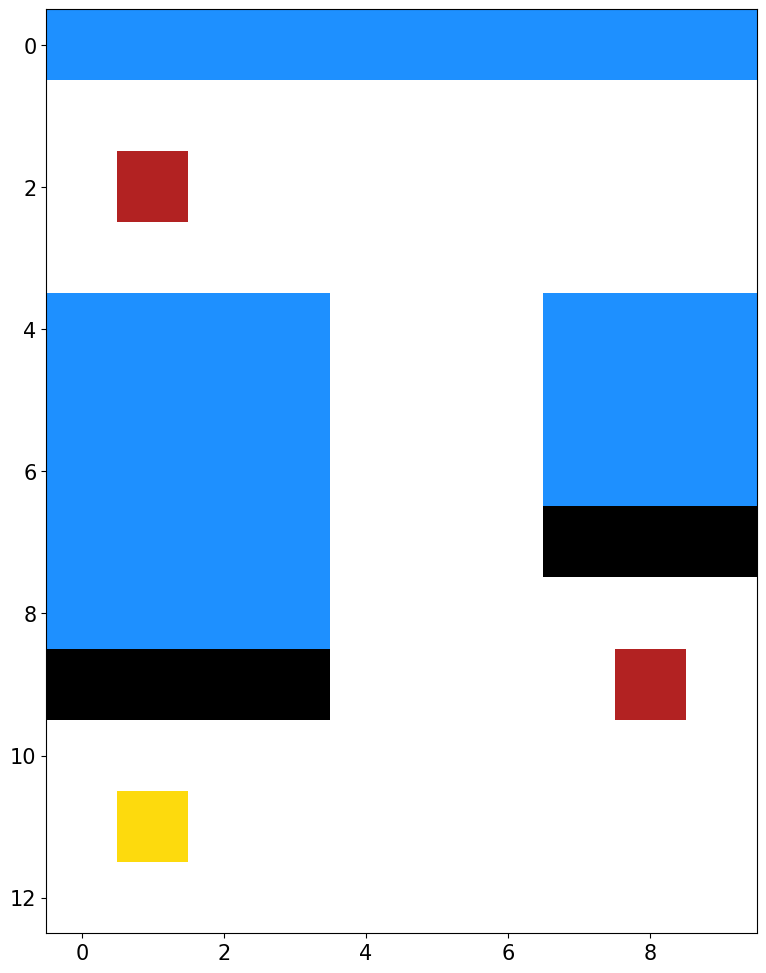

In [2]:
locations = [(2, 1), (9, 8)]
rewards = [5000, 250]


example_env = GridWorld(goal_locations=locations, goal_rewards=rewards)

paint_gridworld(example_env)

# Create an RL Agent

Implement either SARSA or Q-learning to determine how your agent executes actions and learns from the gathered rewards.

In [3]:
import numpy as np

def learn_policy(env: GridWorld,
                 n_episodes: int = 1,
                 method: str = 'sarsa',
                 policy_type: str = 'epsilon_greedy',
                 eta: float = 0.1,
                 epsilon: float = 0.1,
                 gamma: float = 0.9,
                 temperature: float = 1.0,
                 optimistic: bool = False
                ) -> tuple[np.ndarray, list[float], list[int]]:
    """
    Solve GridWorld using SARSA or Q-learning,
    supporting epsilon-greedy or softmax policies.
    """

    def select_action(Q, state, epsilon, temperature):
        r, c = state
        if policy_type == 'epsilon_greedy':
            if np.random.rand() < epsilon:
                return np.random.randint(4)
            qvals = Q[r, c]
            best = np.flatnonzero(qvals == qvals.max())
            return np.random.choice(best)
        else:  # softmax
            qvals = Q[r, c]
            exp_q = np.exp((qvals - np.max(qvals)) / temperature)
            probs = exp_q / exp_q.sum()
            return np.random.choice(4, p=probs)

    height, width = env._shape

    if not optimistic:
        Q = np.zeros((height, width, 4))
    else:
        Q = np.full((height, width, 4), 5_000)  # optimistic

    total_rewards = []
    episode_lengths = []

    for _ in range(n_episodes):
        _, state_idx, _, _ = env.reset()
        state = env.get_loc_from_state(state_idx)
        action = select_action(Q, state, epsilon, temperature)
        total_reward, steps, done = 0, 0, False

        while not done:
            _, next_idx, reward, done = env.step(action)
            next_state = env.get_loc_from_state(next_idx)
            next_action = select_action(Q, next_state, epsilon, temperature)

            r0, c0 = state
            r1, c1 = next_state

            if method == 'sarsa':
                target = reward + (0 if done else gamma * Q[r1, c1, next_action])
            else:  # q_learning
                target = reward + (0 if done else gamma * Q[r1, c1].max())

            Q[r0, c0, action] += eta * (target - Q[r0, c0, action])

            state, action = (next_state, next_action) if method == 'sarsa' \
                             else (next_state, select_action(Q, next_state, epsilon, temperature))
            total_reward += reward
            steps += 1

        total_rewards.append(total_reward)
        episode_lengths.append(steps)

    policy = np.argmax(Q, axis=2)
    return policy, total_rewards, episode_lengths

# Learn Policy for Dual Targets with Differing Rewards
Learn a policy for an environment with two goals, where the more distant goal is considerably more valuable. 

TIP: Test the learning algorithm with an environment that has just a single reward, and in different positions. 

TIP: Modify the relative rewards between the two goals to see changes in behavior. 

Policy = [[0 0 0 0 0 0 0 0 0 0]
 [0 2 1 2 2 1 1 1 3 3]
 [0 0 3 0 1 0 0 0 0 0]
 [1 0 0 3 3 0 0 3 0 0]
 [0 0 0 0 0 1 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 1 1 0 0 2]
 [0 0 0 1 0 0 2 1 1 0]
 [0 1 1 1 0 0 0 0 0 0]
 [0 0 1 0 2 1 0 0 1 0]]
Total Rewards = [-100.0, -100.0, 250.0, 250.0, -100.0, -100.0, 250.0, 250.0, -100.0, -100.0, -100.0, -100.0, -100.0, 5000.0, -100.0, 0.0, -100.0, -100.0, -100.0, -100.0, -100.0, 5000.0, -100.0, -100.0, -100.0, 5000.0, -100.0, -100.0, -100.0, 5000.0, -100.0, 5000.0, 5000.0, -100.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5

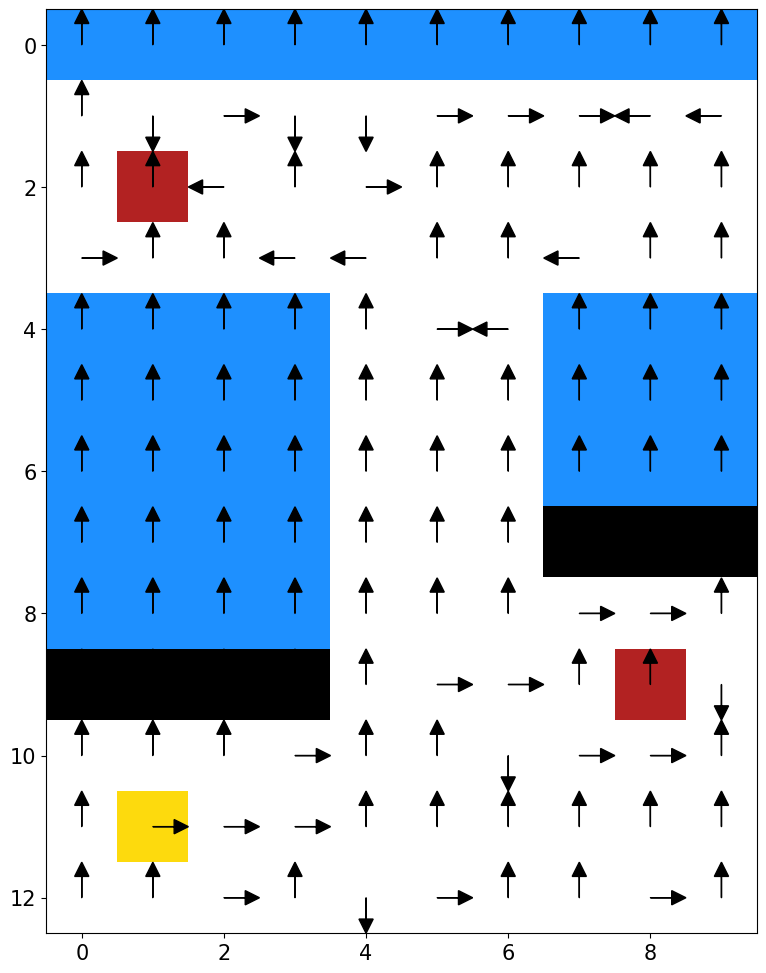

In [4]:
goal_locations = [(2, 1), (9, 8)]
goal_rewards = [5000, 250]

env = GridWorld(goal_locations, goal_rewards)

policy, total_rewards, total_steps = learn_policy(env, n_episodes=5000, method='sarsa', eta=0.1,
                                    policy_type='softmax', gamma=0.999, temperature=0.1, optimistic=True)

print(f"Policy = {policy}")
print(f"Total Rewards = {total_rewards}")
print(f"Total Steps = {total_steps}")

paint_gridworld(env, actions=policy)

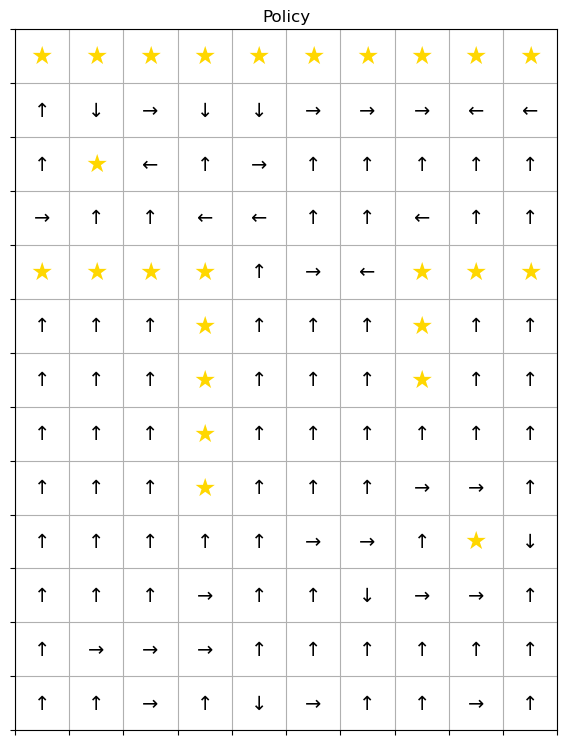

In [5]:
# Do your plots below! Include any new function definitions in this jupyter notebook!
def plot_policy(policy: np.ndarray, terminal_locs=None, title="Learned Policy"):
    """
    Visualize the learned policy on a grid (flipped vertically to match (0,0) at bottom-left).

    Args:
        policy: A 2D array of shape (height, width) with actions (0=↑, 1=→, 2=↓, 3=←).
        terminal_locs: Optional list of (row, col) terminal states to highlight.
        title: Title for the plot.
    """
    height, width = policy.shape
    action_arrows = {
        0: '↑',
        1: '→',
        2: '↓',
        3: '←'
    }

    fig, ax = plt.subplots(figsize=(width * 0.7, height * 0.7))
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    ax.set_xticks(np.arange(width + 1))
    ax.set_yticks(np.arange(height + 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True)

    for i in range(height):
        for j in range(width):
            flipped_i = height - i - 1  # Flip vertically
            if terminal_locs and (i, j) in terminal_locs:
                ax.text(j + 0.5, flipped_i + 0.5, "★", fontsize=18, ha='center', va='center', color='gold')
            else:
                arrow = action_arrows[policy[i, j]]
                ax.text(j + 0.5, flipped_i + 0.5, arrow, fontsize=14, ha='center', va='center')

    ax.set_title(title)
    plt.show()


# policy, total_rewards, episode_lengths = learn_policy(env, n_episodes=2000)

plot_policy(policy, env._terminal_locs, title="Policy")


In [6]:
def plot_learning_curves(total_rewards: list[float],
                         episode_lengths: list[int]) -> None:
    """
    Plot learning curves for a single run, with x-axis labeled at episode_counts/10.

    Args:
        total_rewards: List of total rewards per episode.
        episode_lengths: List of number of steps per episode.
    """
    n_episodes = len(total_rewards)
    episodes   = np.arange(1, n_episodes + 1)

    step = n_episodes // 10
    tick_positions = np.arange(0, n_episodes + 1, step)

    tick_labels = (tick_positions // 10).astype(int)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    ax1.plot(episodes, total_rewards, label="Cumulative Reward", color='royalblue')
    ax1.set_ylabel("Cumulative Reward")
    ax1.set_title("Learning Curve: Cumulative Reward per Episode")
    ax1.grid(True)
    ax1.legend()

    ax2.plot(episodes, episode_lengths, label="# Steps", color='darkorange')
    ax2.set_ylabel("Number of Steps")
    ax2.set_xlabel("Episodes (×10)")
    ax2.set_title("Learning Curve: Steps per Episode")
    ax2.grid(True)
    ax2.legend()

    ax2.set_xticks(tick_positions)
    ax2.set_xticklabels(tick_labels)

    plt.tight_layout()
    plt.show()

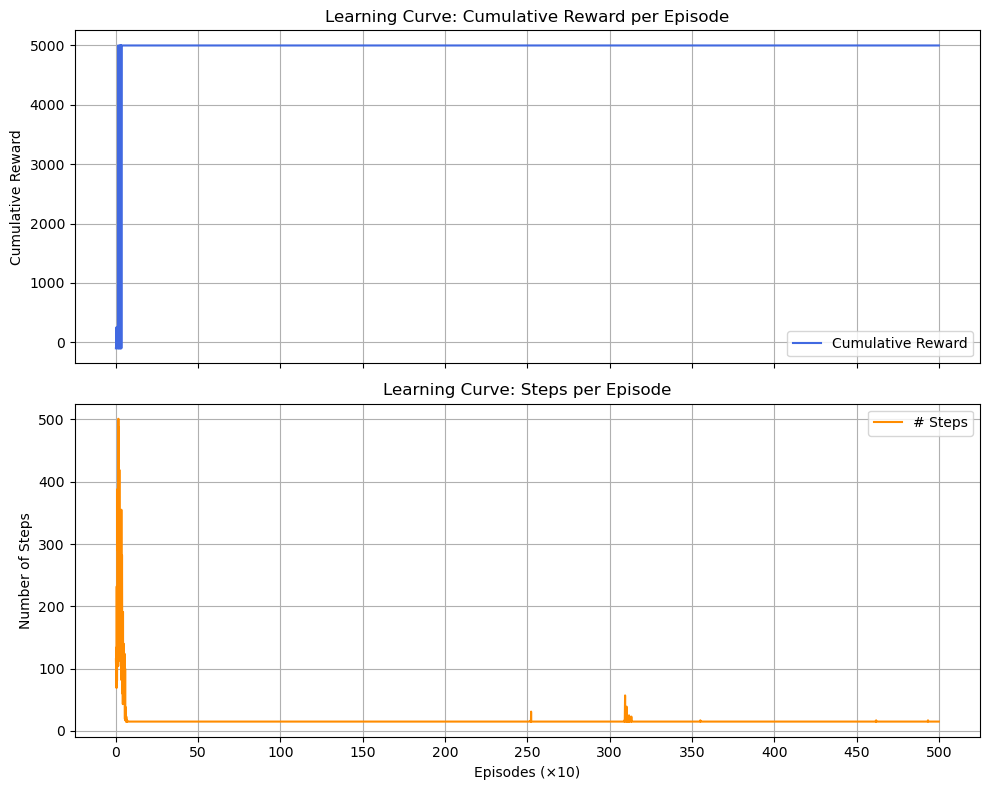

In [7]:
plot_learning_curves(total_rewards, total_steps)

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_avg_learning_curves(env_class,
                             n_episodes=100,
                             n_runs=20,
                             method='sarsa',
                             policy_type='epsilon_greedy',
                             eta=0.1,
                             epsilon=0.1,
                             gamma=0.999,
                             temperature=1.0,
                             optimistic=False,
                             return_final_steps=True):
    """
    Run learn_policy n_runs times, average reward & steps per episode,
    and plot line graphs with x-axis labels in episode_counts/10,
    now including very slim error bars to avoid overlap.

    Args:
        env_class: callable that returns a fresh GridWorld instance.
        n_episodes: episodes per run.
        n_runs: number of independent runs.
        method: 'sarsa' or 'q_learning'.
        policy_type: 'epsilon_greedy' or 'softmax'.
        eta: learning rate.
        epsilon: for epsilon-greedy.
        gamma: Discount factor.
        temperature: for softmax.
        optimistic: whether to use optimistic initialization.
        return_final_steps: if True, returns the final average steps (float).
    """
    # Collect data
    all_rewards = np.zeros((n_runs, n_episodes), dtype=float)
    all_steps   = np.zeros((n_runs, n_episodes), dtype=float)

    for run in range(n_runs):
        env = env_class()
        _, rewards, steps = learn_policy(
            env,
            n_episodes=n_episodes,
            method=method,
            policy_type=policy_type,
            epsilon=epsilon,
            eta=eta,
            gamma=gamma,
            temperature=temperature,
            optimistic=optimistic
        )
        all_rewards[run, :] = rewards
        all_steps[run, :]   = steps

    # Compute mean and std
    mean_rewards = all_rewards.mean(axis=0)
    std_rewards  = all_rewards.std(axis=0)
    mean_steps   = all_steps.mean(axis=0)
    std_steps    = all_steps.std(axis=0)

    episodes = np.arange(1, n_episodes + 1)

    # Tick positions and labels
    step = n_episodes // 10
    tick_positions = np.arange(0, n_episodes + 1, step)
    tick_labels = (tick_positions // 10).astype(int)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

    # Plot cumulative reward with slim error bars
    ax1.errorbar(
        episodes, mean_rewards, yerr=std_rewards,
        fmt='-o', color='royalblue',
        ecolor='royalblue', elinewidth=0.5, capsize=1, alpha=0.7,
        label="Avg Reward ±1σ"
    )
    ax1.set_ylabel("Cumulative Reward")
    ax1.set_title("Average Learning Curve: Reward")
    ax1.grid(True)
    ax1.legend()

    # Plot steps with slim error bars
    ax2.errorbar(
        episodes, mean_steps, yerr=std_steps,
        fmt='-x', color='darkorange',
        ecolor='darkorange', elinewidth=0.5, capsize=1, alpha=0.7,
        label="Avg Steps ±1σ"
    )
    ax2.set_ylabel("Steps")
    ax2.set_xlabel("Episode (×10)")
    ax2.set_title("Average Learning Curve: Steps")
    ax2.grid(True)
    ax2.legend()

    ax2.set_xticks(tick_positions)
    ax2.set_xticklabels(tick_labels)

    plt.tight_layout()
    plt.show()

    if return_final_steps:
        return mean_steps[-1]

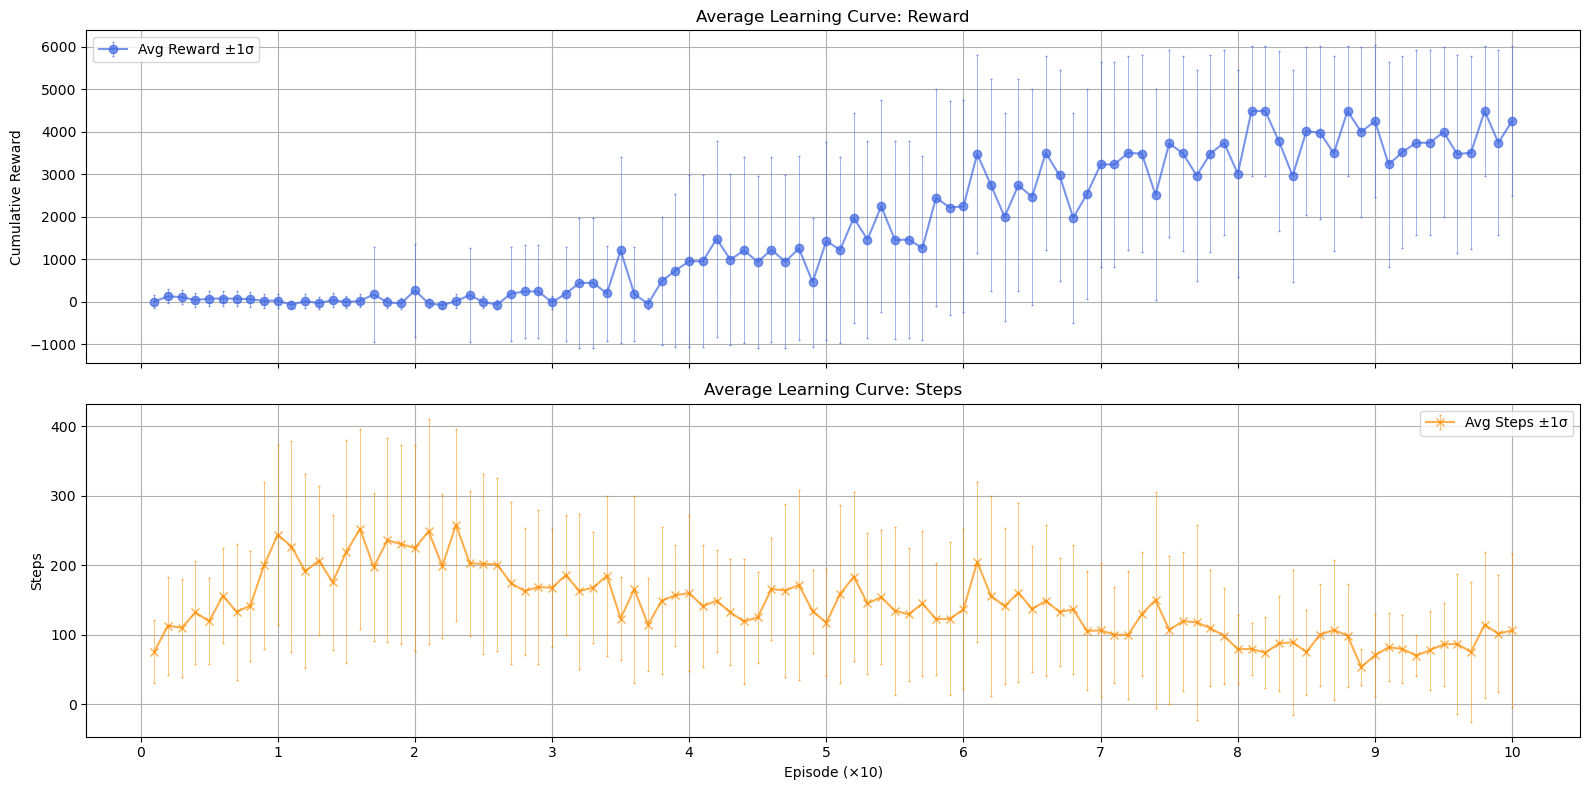

105.95


In [ ]:
final = plot_avg_learning_curves(
    lambda: GridWorld(goal_locations, goal_rewards),
    n_episodes=500,
    n_runs=20,
    method='sarsa',
    policy_type='softmax',
    eta=0.1,
    temperature=0.1,
    gamma=0.999,
    optimistic=True,
    
)

# {'eta': 0.1, 'epsilon': 0.1, 'gamma': 0.999, 'temperature': 0.1}
print(final)

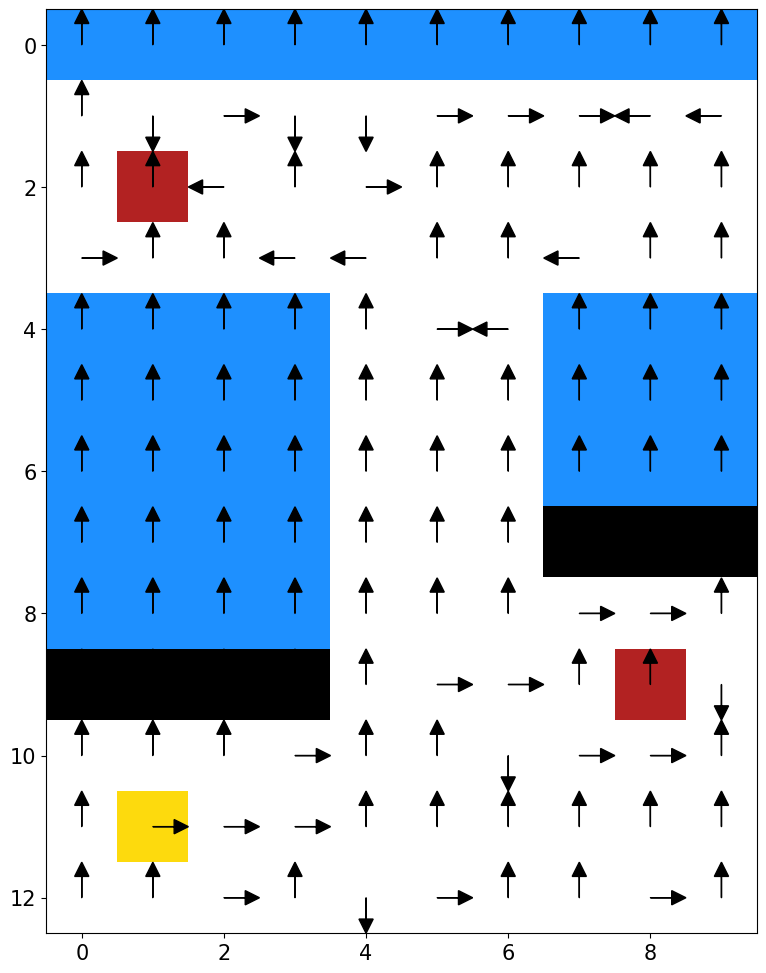

In [12]:


paint_gridworld(env, actions=policy)

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def compare_learning_curves(env_class,
                            methods=['sarsa'],
                            policy_types=['epsilon_greedy', 'softmax'],
                            n_episodes: int = 100,
                            n_runs: int = 20,
                            eta: float = 0.1,
                            epsilon: float = 0.1,
                            gamma: float = 0.999,
                            temperature: float = 1.0,
                            optimistic: bool = False,
                            return_final_steps: bool = False):
    """
    Run learn_policy n_runs times for each (method, policy_type) combo,
    average the results, and overlay the mean curves (no error bars).

    Args:
        env_class: callable returning a fresh GridWorld instance
        methods: list of methods, e.g. ['sarsa', 'q_learning']
        policy_types: list of policy selectors, e.g. ['epsilon_greedy','softmax']
        n_episodes: episodes per run
        n_runs: number of independent runs
        eta: learning rate
        epsilon: ε for ε-greedy
        gamma: discount factor
        temperature: softmax temperature
        optimistic: whether to use optimistic init
        return_final_steps: if True, returns dict of final average steps
    """
    n_episodes = int(n_episodes)
    n_runs     = int(n_runs)

    combos = [(m, p) for m in methods for p in policy_types]
    method_names = {'q_learning': 'Q-learning', 'sarsa': 'SARSA'}
    policy_names = {'epsilon_greedy': 'ε-Greedy', 'softmax': 'Softmax'}
    labels = [f"{method_names[m]} ({policy_names[p]})" for m, p in combos]

    # storage
    mean_R = {}
    mean_S = {}

    # run simulations
    for combo in combos:
        m, policy_type = combo
        rewards_accum = np.zeros((n_runs, n_episodes), dtype=float)
        steps_accum   = np.zeros((n_runs, n_episodes), dtype=float)

        for run in range(n_runs):
            env = env_class()
            _, rewards, steps = learn_policy(
                env,
                n_episodes=n_episodes,
                method=m,
                policy_type=policy_type,
                eta=eta,
                epsilon=epsilon,
                gamma=gamma,
                temperature=temperature,
                optimistic=optimistic
            )
            rewards_accum[run] = rewards
            steps_accum[run]   = steps

        mean_R[combo] = rewards_accum.mean(axis=0)
        mean_S[combo] = steps_accum.mean(axis=0)

    # prepare x-axis
    episodes   = np.arange(1, n_episodes+1)
    step_size  = max(1, n_episodes//10)
    ticks      = np.arange(0, n_episodes+1, step_size)
    tick_labels = (ticks // 10).astype(int)

    # plot cumulative reward
    plt.figure(figsize=(10,8))
    for combo, label in zip(combos, labels):
        plt.plot(episodes, mean_R[combo], label=label)
    plt.title("Comparison: Average Cumulative Reward per Episode")
    plt.xlabel("Episode (×10)")
    plt.ylabel("Cumulative Reward")
    plt.xticks(ticks, tick_labels)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # plot steps
    plt.figure(figsize=(10,5))
    for combo, label in zip(combos, labels):
        plt.plot(episodes, mean_S[combo], label=label)
    plt.title("Comparison: Average Steps per Episode")
    plt.xlabel("Episode (×10)")
    plt.ylabel("Number of Steps")
    plt.xticks(ticks, tick_labels)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    if return_final_steps:
        return {label: int(mean_S[combo][-1]) for combo, label in zip(combos, labels)}


In [ ]:
# Compare SARSA with ε-greedy vs. SARSA with softmax
final = compare_learning_curves(
    env_class=lambda: GridWorld(goal_locations, goal_rewards),
    methods=['sarsa'],
    policy_types=['epsilon_greedy', 'softmax'],
    n_episodes=500,
    n_runs=20,
    eta=0.9,
    epsilon=0.005,
    gamma=0.999,
    temperature=0.1,
    optimistic=True,
    return_final_steps=True
)

# {'eta': 0.5, 'epsilon': 0.01, 'gamma': 0.999}
# {'eta': 0.9, 'gamma': 0.999, 'temperature': 0.1}


In [ ]:
for i in final:
    print(f"{i}: {final[i]}")

SARSA (ε-Greedy): 120
SARSA (Softmax): 141


In [ ]:
def optimise_parameters(env_class,
                        method: str,
                        policy_type: str,
                        param_grid: dict,
                        n_episodes: int = 100,
                        n_runs: int = 20,
                        base_eta: float = 0.1,
                        base_epsilon: float = 0.1,
                        base_gamma: float = 0.999,
                        base_temperature: float = 1.0,
                        optimistic: bool = False):
    """
    Sequentially optimise hyperparameters: for each param in param_grid,
    test values, pick that with lowest final avg steps, update base params,
    plot bar chart, and print mapping of value -> final avg steps.

    Args:
        env_class: callable returning a fresh GridWorld
        method: 'sarsa' or 'q_learning'
        policy_type: 'epsilon_greedy' or 'softmax'
        param_grid: dict of {param_name: list of values}
        n_episodes: episodes per run
        n_runs: number of runs to average
        base_eta: default learning rate
        base_epsilon: default epsilon
        base_gamma: default gamma
        base_temperature: default temperature
        optimistic: whether to use optimistic init
    Returns:
        best_params: dict of best parameter values found
    """
    best_params = {
        'eta': base_eta,
        'epsilon': base_epsilon,
        'gamma': base_gamma,
        'temperature': base_temperature
    }

    for param, values in param_grid.items():
        final_steps = []
        for val in values:
            call_params = best_params.copy()
            call_params[param] = val
            steps_runs = np.zeros(n_runs)
            for run in range(n_runs):
                env = env_class()
                _, _, steps = learn_policy(
                    env,
                    n_episodes=n_episodes,
                    method=method,
                    policy_type=policy_type,
                    **call_params,
                    optimistic=optimistic
                )
                steps_runs[run] = steps[-1]
            avg_steps = steps_runs.mean()
            final_steps.append(avg_steps)

        # Print mapping for personal use
        results_dict = dict(zip(values, final_steps))
        print(f"Results for parameter '{param}': {results_dict}")

        # Select best
        best_index = int(np.argmin(final_steps))
        best_val = values[best_index]
        best_params[param] = best_val

        # Plot bar chart
        plt.figure(figsize=(8, 5))
        plt.bar([str(v) for v in values], final_steps, color='skyblue')
        plt.axhline(final_steps[best_index], color='red', linestyle='--', label=f"Best: {best_val}")
        plt.title(f"{method.upper()} + {policy_type}: Optimising {param}\nBest = {best_val}")
        plt.xlabel(param)
        plt.ylabel("Final Average Steps")
        plt.legend()
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()

    return best_params, min(final_steps)


Results for parameter 'epsilon': {0.001: 18.6, 0.005: 36.6, 0.01: 18.4, 0.1: 57.1, 0.2: 69.8, 0.3: 119.45, 0.5: 206.65, 0.9: 201.75, 0.999: 117.15}


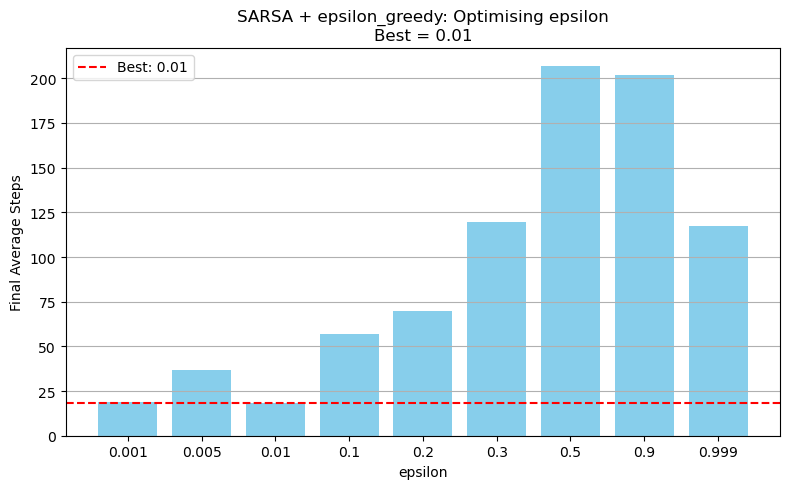

Results for parameter 'gamma': {0.001: 123.5, 0.01: 110.3, 0.5: 33.45, 0.9: 40.45, 0.95: 61.95, 0.999: 25.0}


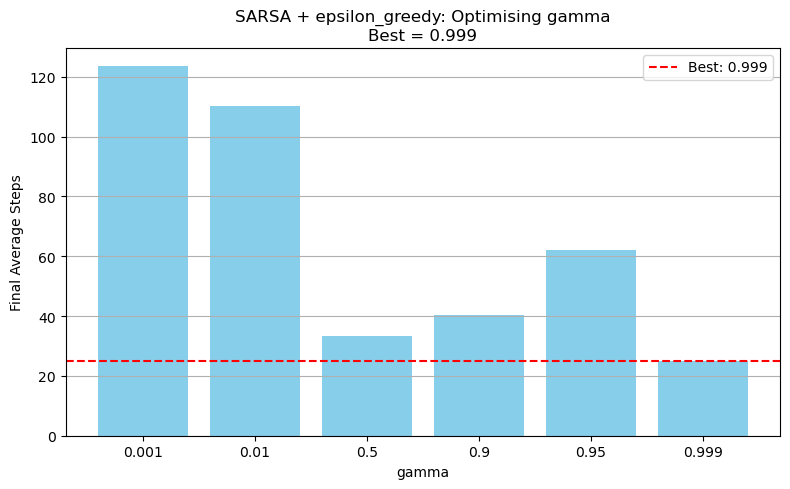

Results for parameter 'eta': {0.001: 17.25, 0.01: 19.45, 0.1: 28.85, 0.2: 18.95, 0.3: 18.25, 0.5: 17.1, 0.9: 17.5}


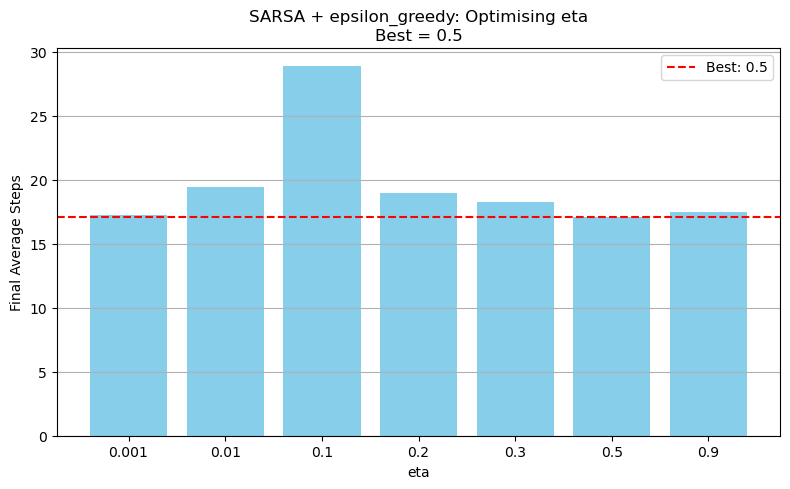

{'eta': 0.5, 'epsilon': 0.01, 'gamma': 0.999, 'temperature': 1.0}
17.1


In [ ]:
# Tune epsilon, gamma, eta for SARSA + ε-greedy
params, final = optimise_parameters(
    env_class=lambda: GridWorld(
        goal_locations,
        goal_rewards
),
    method='sarsa',
    policy_type='epsilon_greedy',
    param_grid={
        'epsilon': [0.001, 0.005, 0.01, 0.1, 0.2, 0.3, 0.5, 0.9, 0.999],
        'gamma':   [0.001, 0.01, 0.5, 0.9, 0.95, 0.999],
        'eta':     [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.9]
    },
    n_episodes=200,
    n_runs=20,
    optimistic=True
)

print(params)
print(final)

Results for parameter 'temperature': {0.1: 16.3, 0.2: 26.3, 0.5: 45.45, 0.9: 61.75, 1: 52.0, 1.25: 64.0, 1.5: 69.35, 1.75: 58.75, 2: 74.2}


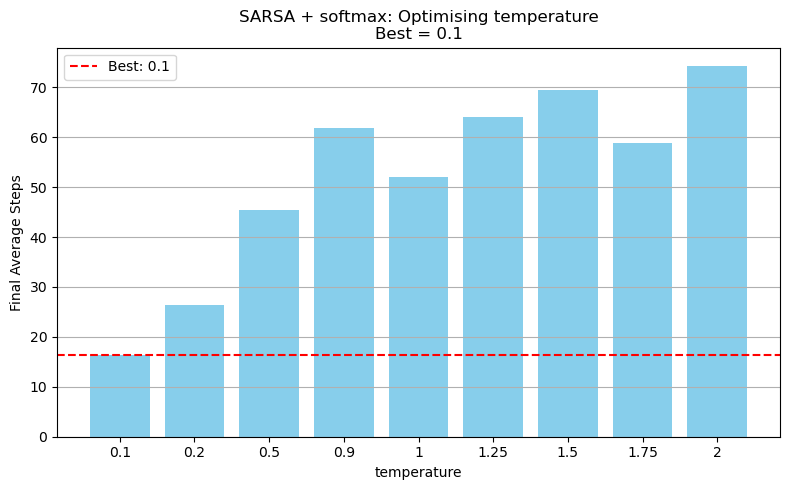

Results for parameter 'gamma': {0.001: 123.05, 0.01: 98.75, 0.5: 57.2, 0.9: 80.55, 0.95: 84.0, 0.999: 15.4}


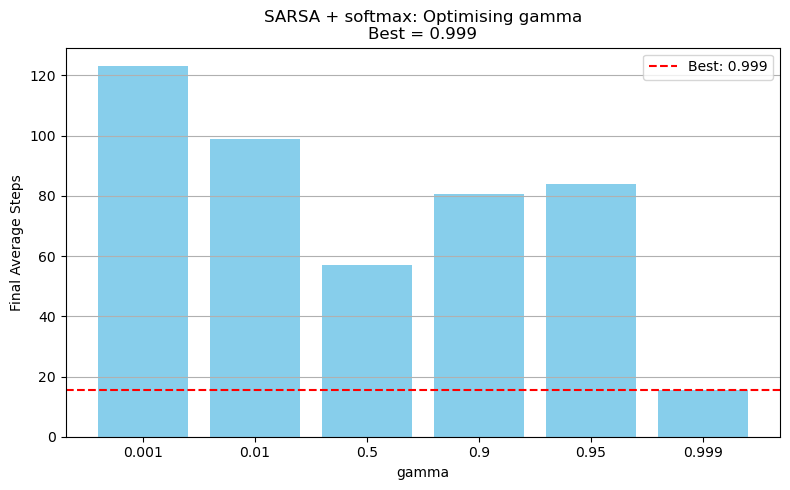

Results for parameter 'eta': {0.001: 50.45, 0.01: 19.35, 0.1: 15.2, 0.2: 21.1, 0.3: 21.1, 0.5: 15.75, 0.9: 15.0}


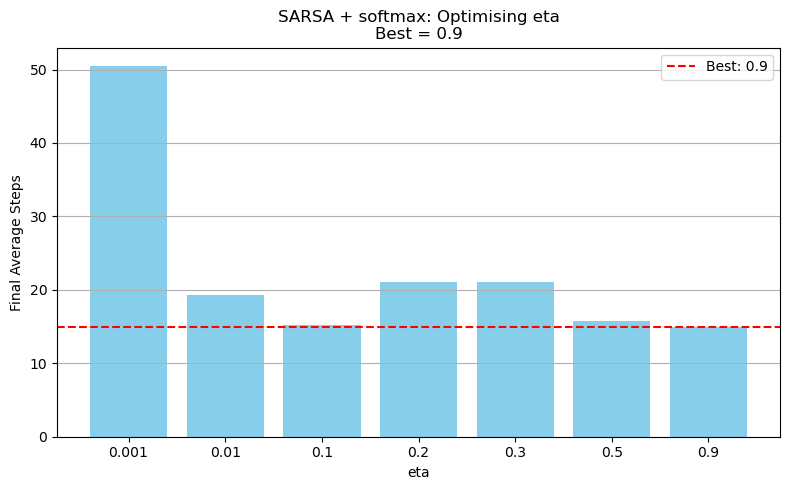

{'eta': 0.9, 'epsilon': 0.1, 'gamma': 0.999, 'temperature': 0.1}
15.0


In [ ]:
# Tune tau, gamma, eta for SARSA + softmax
params, final = optimise_parameters(
    env_class=lambda: GridWorld(
        goal_locations,
        goal_rewards
),
    method='sarsa',
    policy_type='softmax',
    param_grid={
        'temperature': [0.1, 0.2, 0.5, 0.9, 1, 1.25, 1.5, 1.75, 2],
        'gamma':   [0.001, 0.01, 0.5, 0.9, 0.95, 0.999],
        'eta':     [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.9]
    },
    n_episodes=100,
    n_runs=20,
    optimistic=True
)

print(params)
print(final)